In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [2]:
dataset = pd.read_csv('../../datasets/sp_500_stocks/sp500_index.csv')

In [3]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,S&P500
0,2014-12-01,2053.44
1,2014-12-02,2066.55
2,2014-12-03,2074.33
3,2014-12-04,2071.92
4,2014-12-05,2075.37
...,...,...
2512,2024-11-22,5969.34
2513,2024-11-25,5987.37
2514,2024-11-26,6021.63
2515,2024-11-27,5998.74


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
dataset['average_price'] = dataset["S&P500"]
dataset = dataset.drop(columns=["S&P500"])
dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
dataset['quarter'] = dataset['Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 0#'winter'
    elif month in [3, 4, 5]:
        return 1#'spring'
    elif month in [6, 7, 8]:
        return 2#'summer'
    else:
        return 3#'autumn'
dataset['season'] = dataset['Month'].apply(get_season)
dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


days_ago = 30

#dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
#dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
#dataset["price_365_days_ago"] = dataset["average_price"].shift(365)

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber"] #, "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]
fieldsPrice = ["average_price"]


dataset = dataset.dropna().reset_index(drop=True)

dataset

,Date,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber
0,2014-12-01,735568,2053.44,0,12,2014,335,49,1,0,4,0,1
1,2014-12-02,735569,2066.55,1,12,2014,336,49,0,0,4,0,2
2,2014-12-03,735570,2074.33,2,12,2014,337,49,0,0,4,0,3
3,2014-12-04,735571,2071.92,3,12,2014,338,49,0,0,4,0,4
4,2014-12-05,735572,2075.37,4,12,2014,339,49,0,0,4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-11-22,739212,5969.34,4,11,2024,327,47,0,0,4,3,3645
2513,2024-11-25,739215,5987.37,0,11,2024,330,48,0,0,4,3,3648
2514,2024-11-26,739216,6021.63,1,11,2024,331,48,0,0,4,3,3649
2515,2024-11-27,739217,5998.74,2,11,2024,332,48,0,0,4,3,3650


In [6]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [7]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [8]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(blockDf['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = blockDf[blockDf['Date'] < train_max_day].shape[0]
    testSamples = len(blockDf.index) - trainSamples

    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test, blockDf

In [9]:
def getTestSet(dataset0, blockDf0, daysRange):
    min_date = pd.to_datetime(blockDf0['Date'].max())
    max_date = min_date + pd.DateOffset(days=daysRange)
    filtered_df = dataset0[(dataset0['Date'] >= min_date) & (dataset0['Date'] <= max_date)]
    aux = filtered_df.copy()
    aux = aux.drop("Date", axis=1)
    X_test = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test = aux.copy()

    return X_test, Y_test

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

testRanges = [30, 90, 180, 365, 730, 1825]

def getRmse(dataset01, blockDf01, rfModel, testRangesIdx):
    X_test0, Y_test0 = getTestSet(dataset01, blockDf01, testRanges[testRangesIdx])
    y_pred = rfModel.predict(X_test0)
    rmse01 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse01

def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
    return rmse0

def testTfAndGetRmse(dataset0, daysOfBlocks0, daysOfTraining0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    return rmse0

def testTfAndGetRmse2(dataset0, daysOfBlocks0, daysOfTraining0, block_size0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    rmseList0 = [rmse0]
    for i in [0, 1, 2]:
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[i])
        rfts.fit(X_train0, Y_train0)
        rmse1 = dict()
        rmse1[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
        rmse1[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
        rmse1[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
        rmse1[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
        rmse1[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
        rmse1[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
        rmseList0.append(rmse1)
    return rmseList0

def getGraphData(presitionDataArray, bRfp, bs):
    all_arr = [bRfp]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in bs:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(presitionDataArray[blockSize][r])

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

def convertListOfDictToDictOfList(dictList0):
    newDict = dict()
    for dict0 in dictList0:
        for key in dict0:
            if key not in newDict:
                newDict[key] = []
            newDict[key].append(dict0[key])
    return newDict

def runTestsAndGetResults(DaysRange, DaysTrainRange, blockSizes):

    daysOfBlocks = DaysRange
    daysOfTraining = DaysTrainRange
    for i in range(len(blockSizes)):
        blockSizes[i] = int(blockSizes[i])

    basicRFPrecision = []
    for i in range(50):
        rmse = testTfAndGetRmse(dataset, DaysRange, DaysTrainRange)
        basicRFPrecision.append(rmse)
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)

    precisionNonOverlapping = dict()
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
            precisionNonOverlapping[block_size].append(rmse0)
    
    precisionMovingBlock = dict()
    for block_size in blockSizes:
        precisionMovingBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
            precisionMovingBlock[block_size].append(rmse0)
    
    precisionCircularBlock = dict()
    for block_size in blockSizes:
        precisionCircularBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
            precisionCircularBlock[block_size].append(rmse0)
    
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size])
        precisionMovingBlock[block_size] = convertListOfDictToDictOfList(precisionMovingBlock[block_size])
        precisionCircularBlock[block_size] = convertListOfDictToDictOfList(precisionCircularBlock[block_size])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

def showGraph(basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock, blockSizes):
    all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping, basicRFPrecision, blockSizes)
    all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock, basicRFPrecision, blockSizes)
    all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock, basicRFPrecision, blockSizes)

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    plt.figure()

    bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
    bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
    bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
    set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bp1, '#2C7BB6')
    set_box_color(bp2, '#fdc086')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Non Overlapping')
    plt.plot([], c='#2C7BB6', label='Moving Block')
    plt.plot([], c='#fdc086', label='Circular Block')
    plt.legend()

    plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre alternativas de bootstraps (Train: {DaysTrainRange} días | Test: {DaysRange - DaysTrainRange} días)")
    plt.xlabel("Tamaño de bloque")
    plt.ylabel("RMSE")

In [11]:
def runTestsAndGetResults2(DaysRange, DaysTrainRange, blockSizes):

    basicRFPrecision = []
    precisionNonOverlapping = dict()
    precisionMovingBlock = dict()
    precisionCircularBlock = dict()
    block_size = blockSizes[0]
    precisionNonOverlapping[block_size] = []
    precisionMovingBlock[block_size] = []
    precisionCircularBlock[block_size] = []
    for i in range(50):
        rmseList = testTfAndGetRmse2(dataset, DaysRange, DaysTrainRange, block_size)
        basicRFPrecision.append(rmseList[0])
        precisionNonOverlapping[block_size].append(rmseList[1])
        precisionMovingBlock[block_size].append(rmseList[2])
        precisionCircularBlock[block_size].append(rmseList[3])
    
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)
        
    for block_size0 in blockSizes:
        precisionNonOverlapping[block_size0] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size0])
        precisionMovingBlock[block_size0] = convertListOfDictToDictOfList(precisionMovingBlock[block_size0])
        precisionCircularBlock[block_size0] = convertListOfDictToDictOfList(precisionCircularBlock[block_size0])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

In [12]:
def runTestAndCompareOneSigleBlockSize(TrainDays, bSize):
    bs = [bSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(TrainDays + max(testRanges), TrainDays, bs)
    showGraph(FrRMSE, NoRMSE[bSize], BmRMSE[bSize], CbRMSE[bSize], bs)
    

In [14]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def getLinesGraphData(rfReference):
    ticks0 = []
    rfReferenceMeans = []
    for key in rfReference:
        ticks0.append(str(key))
        rfReferenceMeans.append(sum(rfReference[key]) / len(rfReference[key]))
    rfReferenceMeans
    return rfReferenceMeans, ticks0

def showGraphLinesForOneBlockSize(basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock, descr):
    all_arr0, ticksNames = getLinesGraphData(basicRFPrecision)
    all_arr, ticksNames = getLinesGraphData(precisionNonOverlapping)
    all_arr1, ticksNames = getLinesGraphData(precisionMovingBlock)
    all_arr2, ticksNames = getLinesGraphData(precisionCircularBlock)

    plt.figure()

    bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
    bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
    bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
    bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    #bp3.colo
    # set_box_color(bp3, '#f03b20')
    # set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    # set_box_color(bp1, '#2C7BB6')
    # set_box_color(bp2, '#fdc086')

    plt.legend()

    plt.xticks(range(0, len(ticksNames)), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre algoritmos ({descr})")
    plt.xlabel("Dias del conjunto de pruebas")
    plt.ylabel("RMSE")

In [16]:
def runTrainTimeTest(trainDays, blockSize):
    bs = [blockSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(trainDays + max(testRanges), trainDays, bs)
    graphDescr = f"Train: {trainDays} días, 50 pruebas, bloques {blockSize} muestras"
    showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[blockSize], BmRMSE[blockSize], CbRMSE[blockSize],graphDescr )

In [17]:
def runTestAndCompareOneSigleBlockSize2(TrainDays, bSize):
    bs = [bSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults2(TrainDays + max(testRanges), TrainDays, bs)
    graphDescr = f"Train: {TrainDays} días, 50 pruebas, bloques {bSize} muestras"
    showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[bSize], BmRMSE[bSize], CbRMSE[bSize],graphDescr)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

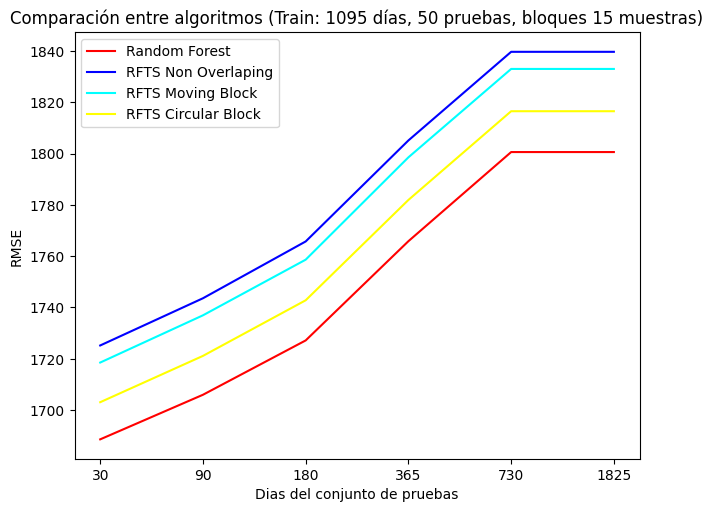

In [19]:

runTestAndCompareOneSigleBlockSize2(int(365 * 3), int(5 * 3))

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

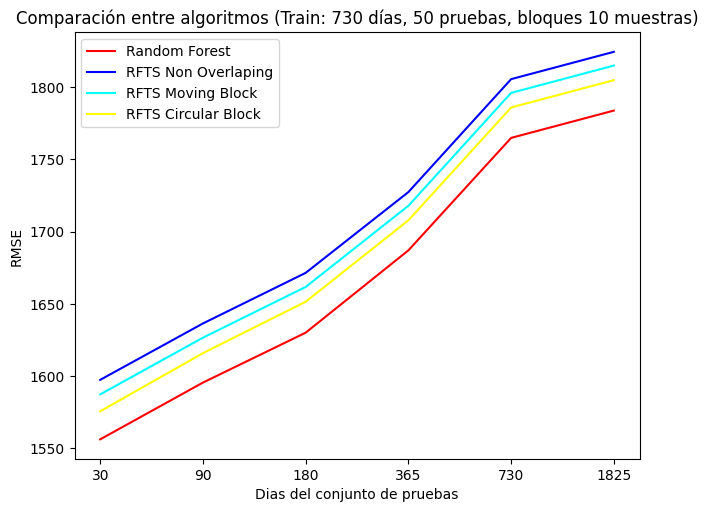

In [20]:
runTestAndCompareOneSigleBlockSize2(365 * 2, 10)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

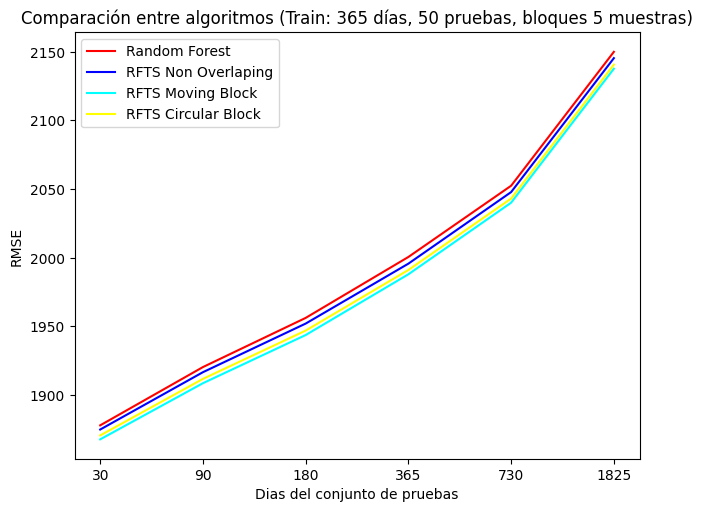

In [21]:
runTestAndCompareOneSigleBlockSize2(365, 5)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

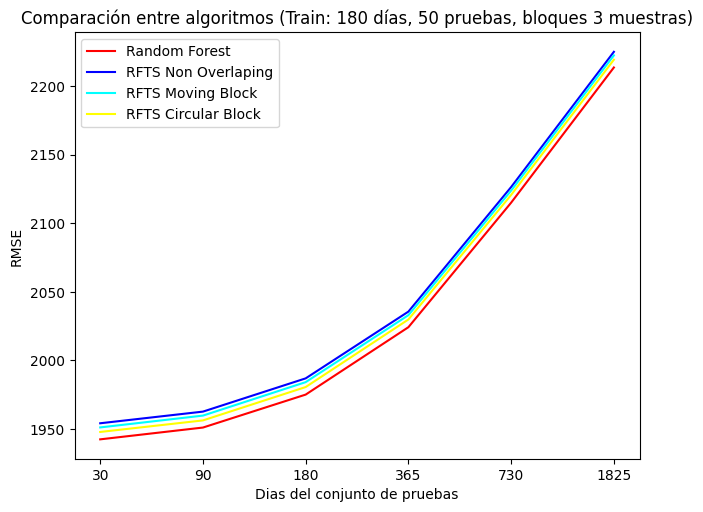

In [22]:
runTestAndCompareOneSigleBlockSize2(180, 3)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

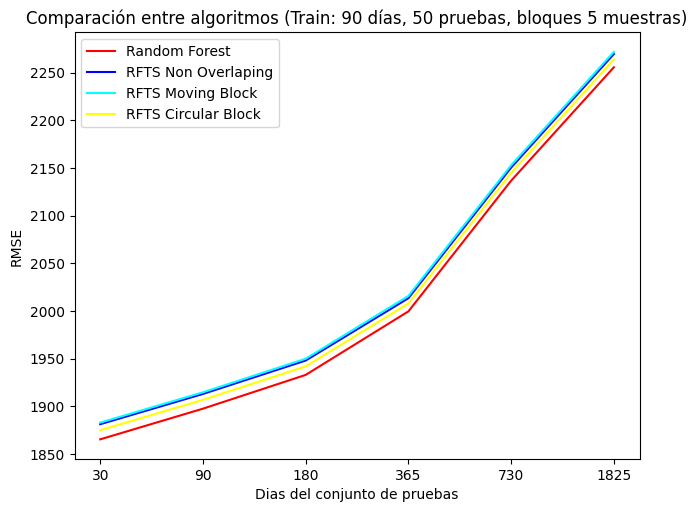

In [23]:
runTestAndCompareOneSigleBlockSize2(90, 5)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

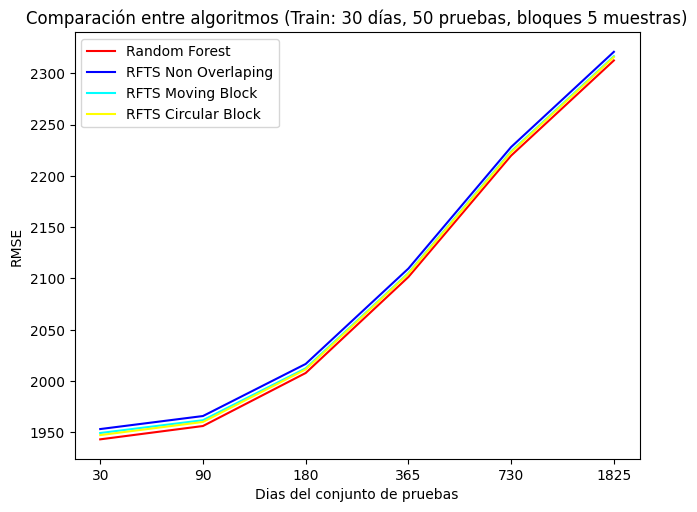

In [24]:
runTestAndCompareOneSigleBlockSize2(30, 5)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

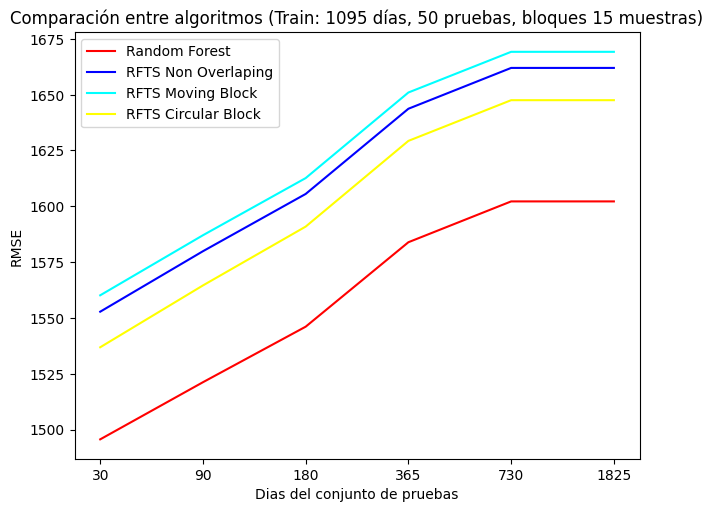

In [25]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), 15)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

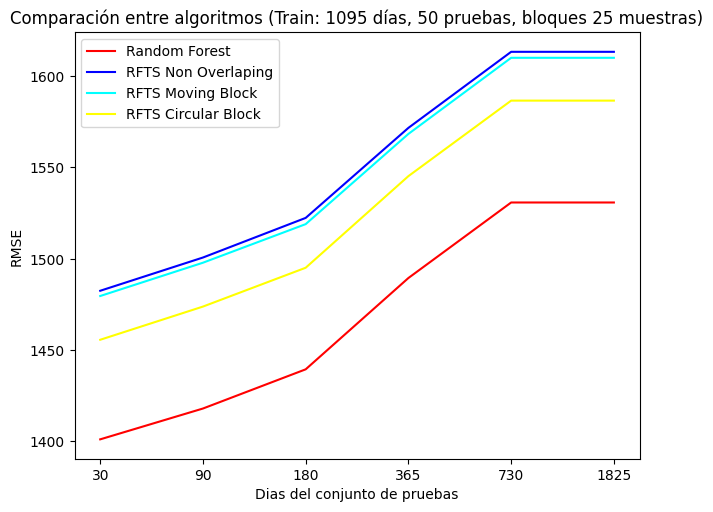

In [26]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), (5 * 5))